# Implementing a Decision Tree Machine Learning Algorithm
> In this notebook, we will implement a Decision Tree algorithm using a popular machine learning library such as `scikit-learn`. Decision Trees are a versatile machine learning algorithm capable of performing both classification and regression tasks.

> This is basic machine learning algorithm that is used as a stepping stone to others such as random forests.

> We'll use the 'titanic' dataset, available at [kaggle](https://www.kaggle.com/datasets/heptapod/titanic). At the end of this implementation, we'll have a tree that is able to predict if a passanger will survive or not the Titanic Sink.

> The model will be evaluted according to precision, recall, and F1 metrics observed

<div align="left">

## Steps:
1. Import necessary libraries.
2. Load and preprocess the dataset.
3. Transform the Data
4. Train a Decision Tree model.
5. Evaluate the model's performance.
6. Visualize the Decision Tree (optional).

</div>


In [356]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support


### 2. Load Dataset from /data folder

In [357]:
# Get root directory of the project
root = Path().resolve().parent
dataset_path = os.path.join(root,'data/train_and_test2.csv')
# Load the dataset
raw_dataset = pd.read_csv(dataset_path)
raw_dataset.describe()

,Passengerid,Age,Fare,Sex,sibsp,zero,zero.1,zero.2,zero.3,zero.4,...,zero.12,zero.13,zero.14,Pclass,zero.15,zero.16,Embarked,zero.17,zero.18,Survived
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.0,1309.0,1309.0,1309.0,1309.0,...,1309.0,1309.0,1309.0,1309.000000,1309.0,1309.0,1307.000000,1309.0,1309.0,1309.000000
mean,655.000000,29.503186,33.281086,0.355997,0.498854,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.294882,0.0,0.0,1.492731,0.0,0.0,0.261268
std,378.020061,12.905241,51.741500,0.478997,1.041658,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.837836,0.0,0.0,0.814626,0.0,0.0,0.439494
min,1.000000,0.170000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
25%,328.000000,22.000000,7.895800,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.000000,0.0,0.0,1.000000,0.0,0.0,0.000000
50%,655.000000,28.000000,14.454200,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.000000,0.0,0.0,2.000000,0.0,0.0,0.000000
75%,982.000000,35.000000,31.275000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.000000,0.0,0.0,2.000000,0.0,0.0,1.000000
max,1309.000000,80.000000,512.329200,1.000000,8.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.000000,0.0,0.0,2.000000,0.0,0.0,1.000000


### 3. Transform the Data

In [358]:
# Creatting extra columns and Dummies
raw_dataset['FamilySize'] = raw_dataset['sibsp'] + raw_dataset['Parch']
raw_dataset['isAlone'] = np.where(raw_dataset['FamilySize'] == 0, 1, 0)
# Avoid Random Numerical Assigining
raw_dataset = pd.get_dummies(raw_dataset,columns=['Embarked'])

# Split Age into groups
raw_dataset['isChild'] = raw_dataset['Age'].apply(lambda x:1 if x < 14 else 0)
raw_dataset['isTeen'] = raw_dataset['Age'].apply(lambda x:1 if x>=14 and x<20 else 0)
raw_dataset['isAdult'] = raw_dataset['Age'].apply(lambda x:1 if x>=20 and x<45 else 0)
raw_dataset['isSenior'] = raw_dataset['Age'].apply(lambda x:1 if x >= 45 else 0)
y_x_columns = ['Survived', 'Sex','Age','Fare', 'isAlone', 'Pclass','isChild','isTeen',
               'isAdult','isSenior','Embarked_0.0', 'Embarked_1.0','Embarked_2.0']
raw_dataset[y_x_columns].head(10)
# To categorize numerical columns, we could also use the cut method in pandas as follows:
# raw_dataset['ageGroups'] = pd.cut(raw_dataset['Age'], bins=[0, 14, 20, 45,200], include_lowest=True, labels=['Child', 'Teen', 'Adult','Senior'])
# raw_dataset = pd.get_dummies(raw_dataset,columns=['ageGroups'])


,Survived,Sex,Age,Fare,isAlone,Pclass,isChild,isTeen,isAdult,isSenior,Embarked_0.0,Embarked_1.0,Embarked_2.0
0,0,0,22.0,7.2500,0,3,0,0,1,0,False,False,True
1,1,1,38.0,71.2833,0,1,0,0,1,0,True,False,False
2,1,1,26.0,7.9250,1,3,0,0,1,0,False,False,True
3,1,1,35.0,53.1000,0,1,0,0,1,0,False,False,True
4,0,0,35.0,8.0500,1,3,0,0,1,0,False,False,True
5,0,0,28.0,8.4583,1,3,0,0,1,0,False,True,False
6,0,0,54.0,51.8625,1,1,0,0,0,1,False,False,True
7,0,0,2.0,21.0750,0,3,1,0,0,0,False,False,True
8,1,1,27.0,11.1333,0,3,0,0,1,0,False,False,True
9,1,1,14.0,30.0708,0,2,0,1,0,0,True,False,False


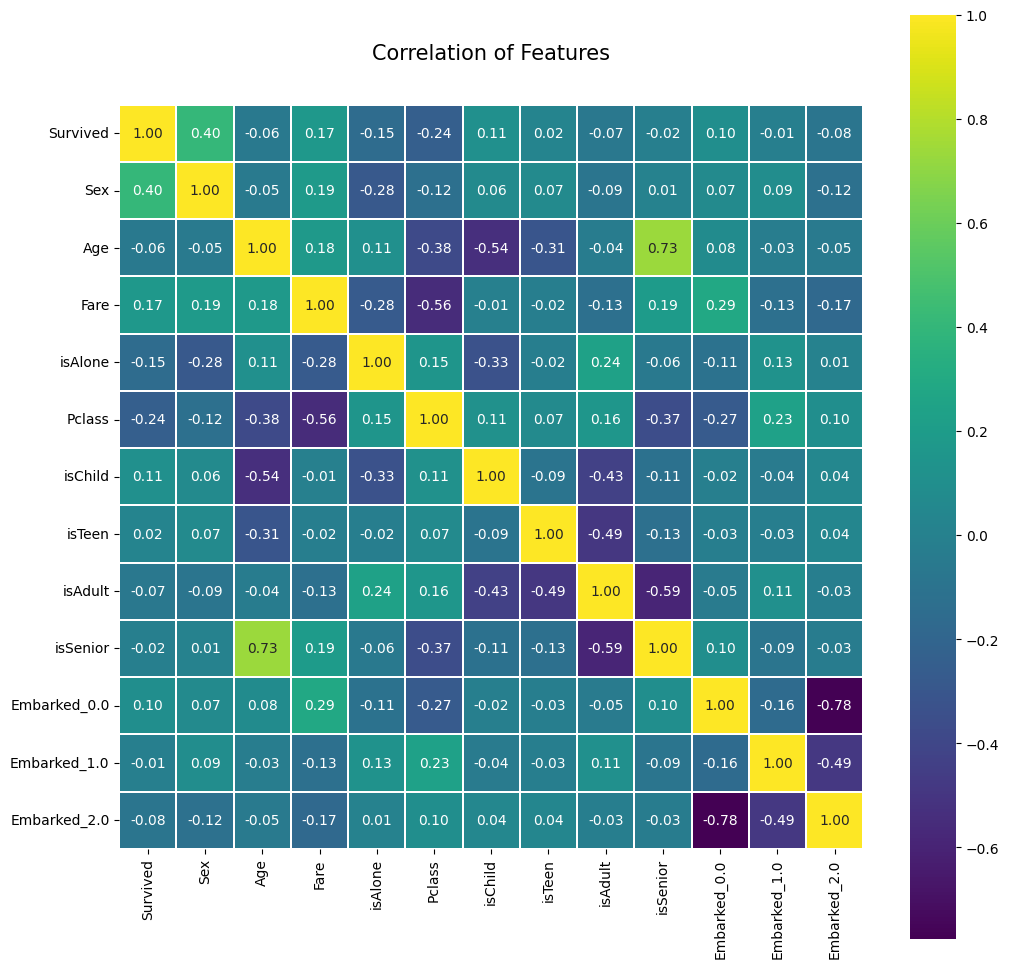

In [359]:

corrMatrix = raw_dataset[y_x_columns].corr()
plt.figure(figsize=(12,12))
plt.title('Correlation of Features', y=1.05, size=15)
sn.heatmap(corrMatrix.astype(float),linewidths=0.1,vmax=1.0, square=True, cmap='viridis', linecolor='white', annot=True,fmt='.2f')
plt.show()
plt.close()

In [360]:
# Define Vectors
X, y =  raw_dataset[['Sex','Fare', 'isAlone', 'Pclass','isChild','isTeen','isAdult','isSenior','Embarked_0.0', 'Embarked_1.0','Embarked_2.0']],raw_dataset['Survived']
# Split into training / Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.40, random_state=42)

Tree Fitted to Training data


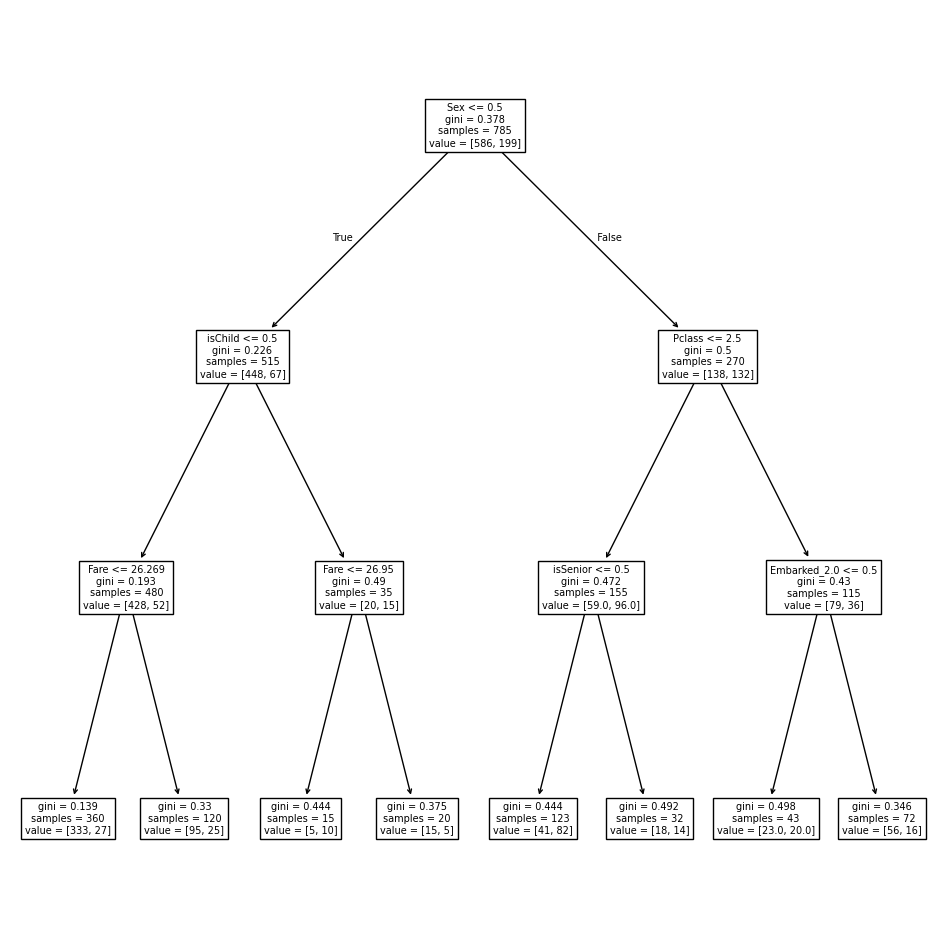

In [361]:
clf = tree.DecisionTreeClassifier(criterion='gini',splitter='best',
                    max_depth=3)
clf.fit(X_train,y_train,)
plt.figure(figsize=(12,12))
tree.plot_tree(clf,max_depth=3,feature_names=['Sex','Fare', 'isAlone', 'Pclass','isChild','isTeen','isAdult','isSenior','Embarked_0.0', 'Embarked_1.0','Embarked_2.0'])
print('Tree Fitted to Training data')

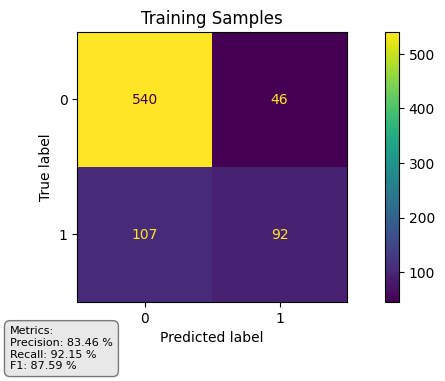

In [362]:
y_train_predicted = clf.predict(X_train)
fig, ax = plt.subplots(figsize=(8, 4))
cm = confusion_matrix(y_train, y_train_predicted)
disp = ConfusionMatrixDisplay(cm)
disp.plot(ax=ax)
ax.set_title('Training Samples')
# Customizations
plt.tight_layout()
precision,recall,fscore,support = precision_recall_fscore_support(y_train,y_train_predicted)
ax.text(
    x=-1,  # x-coordinate of the text
    y=2,  # y-coordinate of the text
    s=f'''Metrics:\nPrecision: {precision[0]*100:.2f} %\nRecall: {recall[0]*100:.2f} %\nF1: {fscore[0]*100:.2f} %''',  # Text string
    fontsize=8,  # Font size
    color="black",  # Text color
    bbox={
        "facecolor": "lightgray",  # Background color of the box
        "edgecolor": "black",  # Border color of the box
        "boxstyle": "round,pad=0.5",  # Box style (e.g., round, square) and padding
        "alpha": 0.5,  # Transparency of the box
    },
)
# Customizations
plt.tight_layout()

Precision: 79.91
Recall: 92.91
F1: 85.92


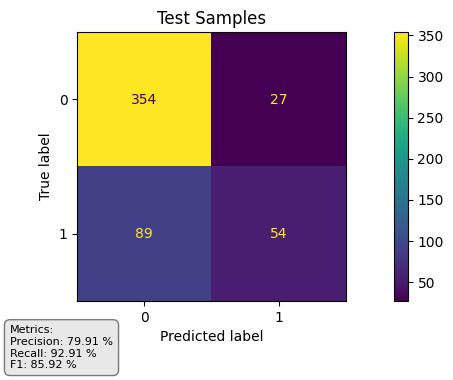

In [363]:
y_test_predicted = clf.predict(X_test)
fig, ax = plt.subplots(figsize=(10, 4))
cm = confusion_matrix(y_test, y_test_predicted)
disp = ConfusionMatrixDisplay(cm)
disp.plot(ax=ax)
precision,recall,fscore,support = precision_recall_fscore_support(y_test,y_test_predicted)
print(f'Precision: {precision[0]*100:.2f}')
print(f'Recall: {recall[0]*100:.2f}')
print(f'F1: {fscore[0]*100:.2f}')
ax.set_title('Test Samples')
# Add a text box with custom notes
ax.text(
    x=-1,  # x-coordinate of the text
    y=2,  # y-coordinate of the text
    s=f'''Metrics:\nPrecision: {precision[0]*100:.2f} %\nRecall: {recall[0]*100:.2f} %\nF1: {fscore[0]*100:.2f} %''',  # Text string
    fontsize=8,  # Font size
    color="black",  # Text color
    bbox={
        "facecolor": "lightgray",  # Background color of the box
        "edgecolor": "black",  # Border color of the box
        "boxstyle": "round,pad=0.5",  # Box style (e.g., round, square) and padding
        "alpha": 0.5,  # Transparency of the box
    },
)
# Customizations
plt.tight_layout()